<a href="https://colab.research.google.com/github/FFI-Vietnam/camtrap-tools/blob/main/MegaDetector/confusion_matrix/03_create-confusion-matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This script evaluates recall accuracy of MegaDetector from a ground-truth dataset
and a result json file. Then it creates a set of visualization of recall values 
on each group of species.

After runnning this script, a 'visualizations' folder is created

visualizations
    |__ 
    
"""

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import os
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# specifies Colab directories and file names
root = '/content/drive/'

dataset_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/dataset'
contain_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning'
image_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/visualization'

ground_truth_file_name = '01_ground-truth-table_Kon-Plong.csv'
MD_result_file_name = 'MegaDetector_result_2021-08-27.json'
taxon_match_table_file_name = '02_taxon-database-with-conservation-status.csv'
confusion_matrix_file_name = '03_confusion-matrix.csv'

In [4]:
# read and save file functions
def read_csv_Google_drive(root, contain_folder, file_name):
  file_path = os.path.join(root, contain_folder, file_name)
  return pd.read_csv(file_path)

def save_csv_Google_drive(df, root, contain_folder, file_name, index=False):
  """
  function to save a csv file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'image_metadata(2020-06-26)_full.csv'
  """
  # save file to Colab runtime storage (will be deleted when this notebook is closed)
  df.to_csv('dataframe.csv', index=index)

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  with open('dataframe.csv', 'r') as f:
    df_file = f.read()

  with open(file_path, 'w') as f:
    f.write(df_file)

  print(f'File is saved to {file_name} in Google Drive at {file_path}')

def save_image_Google_drive(plt, root, contain_folder, file_name):
  """
  function to save an image file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'MD_recall_all-species.jpg'
  """

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  plt.savefig(file_path)
  
  print(f'File is saved to {file_name} in Google Drive at {file_path}')

In [6]:
# read ground-truth table
ground_truth_table = read_csv_Google_drive(root, contain_folder, ground_truth_file_name)
ground_truth_table

,FileName,species_common_name,datetime_created,Flash,batch_group,id
0,197__68974__2019-04-27__10-42-20(1).JPG,Human,2019-04-27 10:42:20,No Flash,0,0
1,197__68974__2019-04-27__10-42-21(2).JPG,Human,2019-04-27 10:42:21,No Flash,0,1
2,197__68974__2019-04-27__10-42-22(3).JPG,Human,2019-04-27 10:42:22,No Flash,0,2
3,197__68974__2019-04-27__10-42-44(4).JPG,Human,2019-04-27 10:42:44,No Flash,1,3
4,197__68974__2019-04-27__10-42-45(5).JPG,Human,2019-04-27 10:42:45,No Flash,1,4
...,...,...,...,...,...,...
110281,196__68890__2019-08-05__17-58-54(2).JPG,NaN,2019-08-05 17:58:54,Fired,85333,110281
110282,196__68890__2019-08-05__17-59-22(1).JPG,NaN,2019-08-05 17:59:22,Fired,85334,110282
110283,196__68890__2019-08-06__06-31-24(1).JPG,Rufous-throated Partridge,2019-08-06 06:31:24,Fired,85335,110283
110284,196__68890__2019-08-06__06-31-54(2).JPG,NaN,2019-08-06 06:31:54,Fired,85336,110284


In [7]:
# read MegaDetector result
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

# print sample result
mega_result['images'][5]

{'detections': [{'bbox': [0.5825, 0.9118, 0.4078, 0.08803],
   'category': '1',
   'conf': 0.849},
  {'bbox': [0.003062, 0.8421, 0.1527, 0.1578],
   'category': '1',
   'conf': 0.214}],
 'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/100/67096/100__67096__2019-04-27__12-50-26(3).JPG',
 'max_detection_conf': 0.849}

In [55]:
# read taxon_match_table
taxon_match_table = read_csv_Google_drive(root, contain_folder, taxon_match_table_file_name)
taxon_match_table.sample(5)

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name,conservation_status
123,2012715,Aves,Passeriformes,Dicruridae,Dicrurus,annectens,"Hodgson, 1836",Crow-billed Drongo,biological,83bdb4cf-566f-489f-9a6c-877f0138305a,Crow-billed Drongo,Least Concern
106,2018237,Mammalia,Cetartiodactyla,Cervidae,Muntiacus,NaN,NaN,Muntiacus Species,biological,a04c522f-8ca1-4c09-85b5-a0f29b8466a8,Muntjac,Not Applicable
71,2002130,Mammalia,Rodentia,Hystricidae,Hystrix,brachyura,"Linnaeus, 1758",Malayan Porcupine,biological,e8490543-5bea-46a7-a326-a02142d2e6e1,Malayan Porcupine,Least Concern
38,2014584,Aves,Passeriformes,Leiotrichidae,Trochalopteron,ngoclinhense,"Eames, Le Trong Trai & Nguyen Cu, 1999",Golden-winged Laughingthrush,biological,7819bf4d-b6c1-4b72-bda8-d4e30b2b4ba4,Golden-winged Laughingthrush,Endangered
97,2008831,Aves,Accipitriformes,Accipitridae,Spilornis,cheela,"Latham, 1790",Crested Serpent-Eagle,biological,9ce674d9-7fbc-4f5b-b7cc-4c57bd947e3f,Crested Serpent Eagle,Least Concern


In [9]:
# sanity check file consistency between MD results and ground-truth data
in_ground_truth_not_MD = []
in_MD_not_ground_truth = []

ground_truth_table = read_csv_Google_drive(root, contain_folder, ground_truth_file_name)

list_of_MD_filename = []
for i in range(len(mega_result['images'])):
  list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

list_of_ground_truth_filename = ground_truth_table['FileName'].to_list()

count_1 = 0
for i in tqdm(range(len(list_of_ground_truth_filename))):
  filename = list_of_ground_truth_filename[i]
  if filename in list_of_MD_filename:
    continue
  count_1 += 1
  in_ground_truth_not_MD.append(filename)

count_2 = 0
for i in tqdm(range(len(mega_result['images']))):
  filename = list_of_MD_filename[i]
  if filename in list_of_ground_truth_filename:
    continue
  count_2 += 1
  in_MD_not_ground_truth.append(filename)

with open('in_ground_truth_not_MD.txt', 'w') as f:
  for i in in_ground_truth_not_MD:
    f.write(i + '\n')
print(f'There are {count_1} files in ground-truth table not found in MegaDetector result. Visit in_ground_truth_not_MD.txt (just created) for details.')

with open('in_MD_not_ground_truth.txt', 'w') as f:
  for i in in_MD_not_ground_truth:
    f.write(i + '\n')
print(f'There are {count_2} files in MegaDetector result not found in ground-truth table. Visit in_MD_not_ground_truth.txt (just created) for details.')


# update ground truth table to contain only files in both
print(f'Ground-truth table original size {len(ground_truth_table)}')
ground_truth_table = ground_truth_table[~ ground_truth_table['FileName'].isin(in_ground_truth_not_MD)]
print(f'Ground-truth table updated size  {len(ground_truth_table)}')

  0%|          | 0/110286 [00:00<?, ?it/s]

  0%|          | 0/110166 [00:00<?, ?it/s]

There are 0 files in ground-truth table not found in MegaDetector result. Visit in_ground_truth_not_MD.txt (just created) for details.
There are 0 files in MegaDetector result not found in ground-truth table. Visit in_MD_not_ground_truth.txt (just created) for details.
Ground-truth table original size 110286
Ground-truth table updated size  110286


In [10]:
def list_labels(mega_result, ground_truth_table, threshold, in_batch=True):
  """
  list actual labels and prediction labels
  @params in_batch: accounts for images in batch. For example if 3 images in a 
                    batch has 3 animals, but MD could detect only one, that 
                    would be enough to be a correct detection.
  @return: a list of actual labels and a list of predection labels
  """

  def has_any_object_in_batch(detection_batch, threshold, category_id):
    for detection in detection_batch:
      for i in range(len(detection)):
        if detection[i]['conf'] > threshold and detection[i]['category'] == category_id:
          return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  list_of_MD_filename = []
  for i in range(len(mega_result['images'])):
    list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  y_actu = []
  y_pred = []

  if in_batch:
    search_range = ground_truth_table['batch_group'].unique()
    column_name = 'batch_group'
  else:
    search_range = ground_truth_table['id'].unique()
    column_name = 'id'

  """
  treat each batch as an image
  # in case batch is blank
  if all rows are blank:
    if all predictions are blank:
      actu.append('Blank')
      pred.append('Blank')
    if there is at least one animal in predictions:
      actu.append('Blank')
      pred.append('Animal')

  # in case batch is not blank
  if there are n distinct animals, e.g. Human and Domestic Dog:
    for each distinct animal
      if any of that animal is correctly detected:
        actu.append(distinct_animal)
        pred.append(animal)
      else:
        actu.append(distinct_animal)
        pred.append('Blank')
  """
  for i in tqdm(range(len(search_range))):
    sub_table = ground_truth_table[ground_truth_table[column_name] == search_range[i]]

    filenames = sub_table['FileName'].to_list()

    # store list of detections for the batch
    detection_batch = []

    for f in filenames:
      try:
        detection = mega_result['images'][list_of_MD_filename.index(f)]['detections']
        detection_batch.append(detection)
      except Exception as e:
        # print(str(e))
        print(mega_result['images'][list_of_MD_filename.index(f)])

    # if all images are blank
    if sub_table['species_common_name'].isnull().sum() == len(sub_table):
      # if any Human is detected
      if has_any_object_in_batch(detection_batch, threshold, '2'):
        y_actu.append('Blank')
        y_pred.append('Human')
      # if any Animal is detected
      elif has_any_object_in_batch(detection_batch, threshold, '1'):
        y_actu.append('Blank')
        y_pred.append('Animal')
      else:
        y_actu.append('Blank')
        y_pred.append('Blank')

    # if there is at least one detection event
    else:
      # list n distinct animal detections
      distinct_animals = sub_table[sub_table['species_common_name'].notnull()]['species_common_name'].unique()

      for animal in distinct_animals:
        
        if animal == 'Human':
          if has_any_object_in_batch(detection_batch, threshold, '2'):
            y_actu.append('Human')
            y_pred.append('Human')
          elif has_any_object_in_batch(detection_batch, threshold, '1'):
            y_actu.append('Human')
            y_pred.append('Animal')
          else:
            y_actu.append('Human')
            y_pred.append('Blank')
        else:
          if has_any_object_in_batch(detection_batch, threshold, '2'):
            y_actu.append(animal)
            y_pred.append('Human')
          elif has_any_object_in_batch(detection_batch, threshold, '1'):
            y_actu.append(animal)
            y_pred.append(animal)
          else:
            y_actu.append(animal)
            y_pred.append('Blank')

  y_pr = np.array(y_pred)
  print('Reduction rate', len(y_pr[y_pr == 'Blank']) / len(y_pr))
  return y_actu, y_pred

y_actu_test, y_pred_test = list_labels(mega_result, ground_truth_table, 0.5, in_batch=True)

110166 images
Generating actual and prediction lists...


  0%|          | 0/85338 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


In [ ]:
# sanity check y_actu and y_pred lists

y_actu = pd.Series(y_actu_test)
y_pred = pd.Series(y_pred_test)

# Test 01: number of images
in_batch = True
if in_batch:
  count = 0
  for i in tqdm(ground_truth_table['batch_group'].unique()):
    sub_table = ground_truth_table[ground_truth_table['batch_group'] == i]
    count += sub_table[sub_table['species_common_name'].notnull()]['species_common_name'].nunique()
else:
  count = len(ground_truth_table)
if (y_actu!='Blank').sum() == count:
  print('Pass test 01')
else:
  print('Failed test 01: Has', (y_actu!='Blank').sum(), 'but expects', count)

  0%|          | 0/79939 [00:00<?, ?it/s]

Failed test 01: Has 25759 but expects 22017


In [ ]:
#@title temporary hidden
def list_labels(mega_result, ground_truth_table, THRESHOLD):
  """
  list actual labels and prediction labels
  """

  def has_object(detections, threshold, category_id):
    for i in range(len(detections)):
      if detections[i]['conf'] > threshold and detections[i]['category'] == category_id:
        return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  files = []
  for i in range(len(mega_result['images'])):
    files.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  y_actu = []
  y_pred = []

  count = 0

  for i in tqdm(range(len(ground_truth_table))):
    try:
      # actual label
      actu = ground_truth_table['species_common_name'].iat[i]

      filename = ground_truth_table['FileName'].iat[i]

      # prediction label

      # if the image has any human
      if has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '2'):
        y_pred.append('Human')
        if str(actu) == 'nan':
          y_actu.append('Blank')
        else:
          y_actu.append(actu)
      # if the image has any animal
      elif has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '1'):
        if str(actu) == 'nan':
          y_pred.append('Animal')
          y_actu.append('Blank')
        else:
          y_pred.append(actu)
          y_actu.append(actu)

      # if not have any human or animal
      elif (not has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '1')) and (not has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '2')):
        y_pred.append('Blank')
        if str(actu) == 'nan':
          y_actu.append('Blank')
        else:
          y_actu.append(actu)    
    except Exception as e:
      count += 1
      # print(str(e))
      pass
  print(count)
  y_pr = np.array(y_pred)
  print('Reduction rate', len(y_pr[y_pr == 'Blank']) / len(y_pr))
  return y_actu, y_pred


y_actu_ground, y_pred_ground = list_labels(mega_result, ground_truth_table, 0.5)

110166 images
Generating actual and prediction lists...


  0%|          | 0/110318 [00:00<?, ?it/s]

9263
Reduction rate 0.7793676710702093


In [ ]:
print('ground', len(y_actu_ground))
print('test  ', len(y_actu_test))

print('ground', len(y_pred_ground))
print('test  ', len(y_pred_test))

print(y_actu_test == y_actu_ground)

for i in range(len(y_pred_test)):
  if y_pred_test[i] != y_pred_ground[i]:

    print(y_pred_test[i], y_pred_ground[i])

# pd.DataFrame({'y_actu_ground':y_actu_ground, 'y_actu_test': y_actu_test})
# pd.DataFrame({'y_pred_ground':y_pred_ground, 'y_pred_test': y_pred_test}).to_csv('prediction.csv')

ground 101055
test   101055
ground 101055
test   101055


In [11]:
def get_taxonomy(species_common_name, level, taxon_match_table):
  """
  get taxonomical class level of a species
  """
  row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
  try:
    taxon_class = row[level.lower()].iat[0]
  except:
    print('     Can not find taxonomy info for', species_common_name)
  return taxon_class

# test
get_taxonomy('Annamite Dark Muntjac', 'family', taxon_match_table)

'Cervidae'

In [12]:
def find_FFI_species_by_taxonomy(taxon_match_table, level, taxonomy):
  """
  returns list of species in a taxonomical group, e.g. class Mammalia, order Rodentia
  """
  sub_df = taxon_match_table[taxon_match_table[level.lower()] == taxonomy]
  
  return sub_df['FFI_species_name'].to_list() 

In [13]:
def create_confusion_matrix(y_actu, y_pred):
  print('Generating confusion matrix...')

  y_actu = pd.Series(y_actu, name='Actual')
  y_pred = pd.Series(y_pred, name='Prediction')
  df_confusion = pd.crosstab(y_pred, y_actu, rownames=['Prediction'], colnames=['Actual'], margins=True)
  
  # collapse rows
  confusion_matrix = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for col in df_confusion.columns:
    all = df_confusion[col]['All']
    animal = all - df_confusion[col]['Blank'] - df_confusion[col]['Human']
    human = df_confusion[col]['Human']
    blank = df_confusion[col]['Blank']
    total = animal + human + blank
    confusion_matrix[col] = [animal, human, blank, total, 0] # leave a blank cell for recall value
  
  # lump the Murid rodent family
  confusion_matrix['Murid'] = confusion_matrix['Murid'] + confusion_matrix['Leopoldamys'] + confusion_matrix['Maxomys']

  # drop columns 
  confusion_matrix.drop(columns=['Moth', 'Bat', 'Flying Insect', 'Leopoldamys', 'Maxomys', 'Butterfly'], inplace=True)
  
  # cast from int to float to save recall value
  confusion_matrix = confusion_matrix.astype('float')

  # add recall row
  for col in confusion_matrix.columns:
    if col == 'Blank':
      confusion_matrix[col][4] = round(int(confusion_matrix[col][2]) / int(confusion_matrix[col][3]), 2)
    elif col == 'Human':
      confusion_matrix[col][4] = round(int(confusion_matrix[col][1]) / int(confusion_matrix[col][3]), 2)
    else:
      confusion_matrix[col][4] = round(int(confusion_matrix[col][0]) / int(confusion_matrix[col][3]), 2)

  return confusion_matrix

confusion_matrix = create_confusion_matrix(y_actu_test, y_pred_test)
# save file to Google Drive
save_csv_Google_drive(confusion_matrix.T, root, contain_folder, confusion_matrix_file_name, index=True)

Generating confusion matrix...
File is saved to 03_confusion-matrix.csv in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning/03_confusion-matrix.csv


In [14]:
def create_confusion_matrix_by_group(taxon_match_table, confusion_matrix, species_group):
  """
  create a confusion matrix by species group, e.g. "ungulates", "small carnivores", "birds", "small mammals (squirrels and rats)", "primates"
  @params species_group: dict {group_common_name: [taxonomical_level, group_scientific_name, except]}
    example: {"Birds":["class", "Aves", []], -> all Birds
              "Small carnivores":["order", "Carnivora", ["Asian Black Bear"]]} -> all carnivores excepts for Bears
  """
  confusion_matrix_by_group = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for group in species_group.keys():
    species_list = find_FFI_species_by_taxonomy(taxon_match_table, 
                                                species_group[group][0], 
                                                species_group[group][1])
    # remove except species, e.g. Asian Black Bear not in Small Carnivores
    species_list = list(set(species_list) - set(species_group[group][2]))
    # remove unnecessary species such as Bat, Maxomys, etc
    species_list = list(set(species_list) & set(confusion_matrix.columns))
    # lump into one group
    confusion_matrix_by_group[group] = confusion_matrix[species_list].astype('float').sum(axis = 1)

  # update recall
  for col in confusion_matrix_by_group.columns:
    if col == 'Human':
      confusion_matrix_by_group[col][4] = round(int(confusion_matrix_by_group[col][1]) / int(confusion_matrix_by_group[col][3]), 2)
    else:
      confusion_matrix_by_group[col][4] = round(int(confusion_matrix_by_group[col][0]) / int(confusion_matrix_by_group[col][3]), 2)
  return confusion_matrix_by_group

confusion_matrix_by_group = \
create_confusion_matrix_by_group(taxon_match_table, confusion_matrix, {'Ungulates'       :['order', 'Cetartiodactyla', []],
                                                                       'Birds'           :['class', 'Aves', []],
                                                                       'Small carnivores':['order', 'Carnivora', ["Asian Black Bear"]],
                                                                       'Small mammals'   :['order', 'Rodentia', []],
                                                                       'Primates'        :['order', 'Primates', ['Human']],
                                                                       'Bear'            :['family', 'Ursidae', []],
                                                                       'Pangolin'        :['family', 'Manidae', []],
                                                                       'Human'           :['species', 'sapiens', []]
                                                                       }) 

In [67]:
def create_confusion_matrix_by_conservation_status(taxon_match_table, confusion_matrix, conservation_status):
  """
  create a confusion matrix by conservation status
  @params conservation_status: list of status
    example: ["Endangered", "Vulnerable"]
  """
  def status_of(species):
    return taxon_match_table[taxon_match_table['FFI_species_name'] == species]['conservation_status'].iat[0]
  
  confusion_matrix_by_conservation_status = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for species in confusion_matrix.columns:
    try: # avoid unrecorded species such as Banded Krait
      if status_of(species) in conservation_status:
        confusion_matrix_by_conservation_status[species] = confusion_matrix[species]
    except:
      pass
  return confusion_matrix_by_conservation_status

confusion_matrix_by_conservation_status = \
create_confusion_matrix_by_conservation_status(taxon_match_table, confusion_matrix, ["Endangered", "Vulnerable", "Critically Endangered"])

confusion_matrix_by_conservation_status

,Asian Black Bear,Asian Small-clawed Otter,Chestnut-eared Laughingthrush,Chinese Serow,Crested Argus,Golden-winged Laughingthrush,Grey-shanked Douc Langur,Impressed Tortoise,Northern Pig-tailed Macaque,Owston's Civet,Sambar,Stump-tailed Macaque,Sunda Pangolin
Animal,10.00,8.00,29.00,29.00,100.00,1.0,4.0,2.0,42.00,135.00,4.0,268.00,5.0
Human,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.00,0.0,0.00,0.0
Blank,5.00,3.00,15.00,6.00,9.00,0.0,0.0,0.0,3.00,24.00,0.0,94.00,0.0
Total,15.00,11.00,44.00,35.00,109.00,1.0,4.0,2.0,45.00,160.00,4.0,362.00,5.0
Recall,0.67,0.73,0.66,0.83,0.92,1.0,1.0,1.0,0.93,0.84,1.0,0.74,1.0


In [16]:
def create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, species_group):
  """
  create a confusion matrix in each species group, e.g. "ungulates", "small carnivores", "birds", "small mammals (squirrels and rats)", "primates"
  @params species_group: list [group_common_name, taxonomical_level, group_scientific_name, except]
    example: + ["Birds", "class", "Aves", []] -> for all Birds
             + ["Small carnivores", "order", "Carnivora", ["Asian Black Bear"]]} -> for all carnivores excepts for Bears
  """
  confusion_matrix_in_group = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  species_list = find_FFI_species_by_taxonomy(taxon_match_table, 
                                              species_group[1], 
                                              species_group[2])
  # remove except species, e.g. Asian Black Bear not in Small Carnivores
  species_list = list(set(species_list) - set(species_group[3]))
  # remove unnecessary species such as Bat, Maxomys, etc
  species_list = list(set(species_list) & set(confusion_matrix.columns))
  # get columns by species
  confusion_matrix_in_group = confusion_matrix[species_list].astype('float')

  # update recall
  for col in confusion_matrix_in_group.columns:
    if col == 'Human':
      confusion_matrix_in_group[col][4] = round(int(confusion_matrix_in_group[col][1]) / int(confusion_matrix_in_group[col][3]), 2)
    else:
      confusion_matrix_in_group[col][4] = round(int(confusion_matrix_in_group[col][0]) / int(confusion_matrix_in_group[col][3]), 2)
  return confusion_matrix_in_group

confusion_matrix_in_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Ungulates', 'order', 'Cetartiodactyla', []])
confusion_matrix_in_group

,Wild Boar,Annamite Dark Muntjac,Lesser Mouse-deer,Muntjac,Northern Red Muntjac,Chinese Serow,Domestic Water Buffalo,Sambar
Animal,29.00,77.00,16.00,5.00,107.00,29.00,70.00,4.0
Human,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Blank,14.00,10.00,1.00,3.00,24.00,6.00,11.00,0.0
Total,43.00,87.00,17.00,8.00,131.00,35.00,81.00,4.0
Recall,0.67,0.89,0.94,0.62,0.82,0.83,0.86,1.0


In [17]:
def visualize_recall_bargraph(group_name, confusion_matrix, threshold, color_dict, num_image_threshold=0, legend_by_color=False, custom_size=None, save_fig=False):
  """
  visualize recall values by bargraph by taxonomical class
  """

  print(f"Generating visualization plot for {group_name}...")
  total = []
  recall = []
  names = []
  colors = []

  image_count = len(mega_result['images'])

  species_list = confusion_matrix.columns.to_list()
  for species in species_list:
    if species not in ['All']:
      if confusion_matrix[species]['Total'] >= num_image_threshold:
        colors.append(color_dict[species])
        recall.append(confusion_matrix[species]['Recall'])
        total.append(confusion_matrix[species]['Total'])
        names.append((species))

  # create df to sort recall values
  recall_stats = pd.DataFrame({'name':names, 'recall':recall, 'total':total, 'colors':colors})
  recall_stats['recall'] = recall_stats['recall'].astype('float')
  recall_stats['total'] = recall_stats['total'].astype('int')
  recall_stats.sort_values('recall', inplace=True, ascending=True)

  # creating the bar plot
  species_name = recall_stats['name'].to_list()
  values = recall_stats['recall'].to_list()
  total = recall_stats['total'].to_list()
  colors = recall_stats['colors'].to_list()
  avg_recall = np.mean(recall_stats['recall'])

  if custom_size:
    fig = plt.figure(figsize=custom_size)
    
  plt.barh(species_name, values, color=colors)
  for i, v in enumerate(values):
    recall_value_text_location = v
    plt.text(recall_value_text_location, i, str(round(v,2)), color='blue', fontweight='bold')
    if not custom_size:
      num_image_text_location = v + 0.09
    else:
      num_image_text_location = v + 1/(1.5*custom_size[0])
    plt.text(num_image_text_location, i, f'{str(total[i])} images', color='blue', fontweight='bold')
  # for i, v in enumerate(total):

  plt.xlabel("Values")
  plt.ylabel("Species name")
  labels = list(color_map.keys())
  if legend_by_color:
    handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]
    plt.legend(handles, labels)
  plt.title(f"Evaluate over {image_count} images for {group_name}" +
            f"\nminimum image amount: {num_image_threshold}" +
            f"\nthreshold:  {threshold}" +
            f"\naverage_recall_value: {round(avg_recall,2)}")
  if save_fig:
    save_image_Google_drive(plt, root, image_folder, save_fig)
  plt.show()


In [56]:
# map color with conservation status
colors = {}
color_map = {
              "Not Evaluated": "lightblue",
              "Data Deficient": "lightyellow",
              "Least Concern": "mediumseagreen",
              "Near Threatened": "olive",
              "Vulnerable": "orange",
              "Endangered": "orangered",
              "Critically Endangered": "maroon",
              "Extinct in the Wild": "black",
              "Extinct": "dimgrey",
              "Not Applicable": "lightgrey"
            }
for name in confusion_matrix.columns:
  try: # for unrecorded species such as Banded Krait
    status = taxon_match_table[taxon_match_table['FFI_species_name'] == name]['conservation_status'].iat[0]
    colors[name] = color_map[status]
  except:
    pass

Generating visualization plot for All species...
File is saved to by independent event/MD_recall_Kon-Plong_all-species_min-20-images.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_all-species_min-20-images.jpg


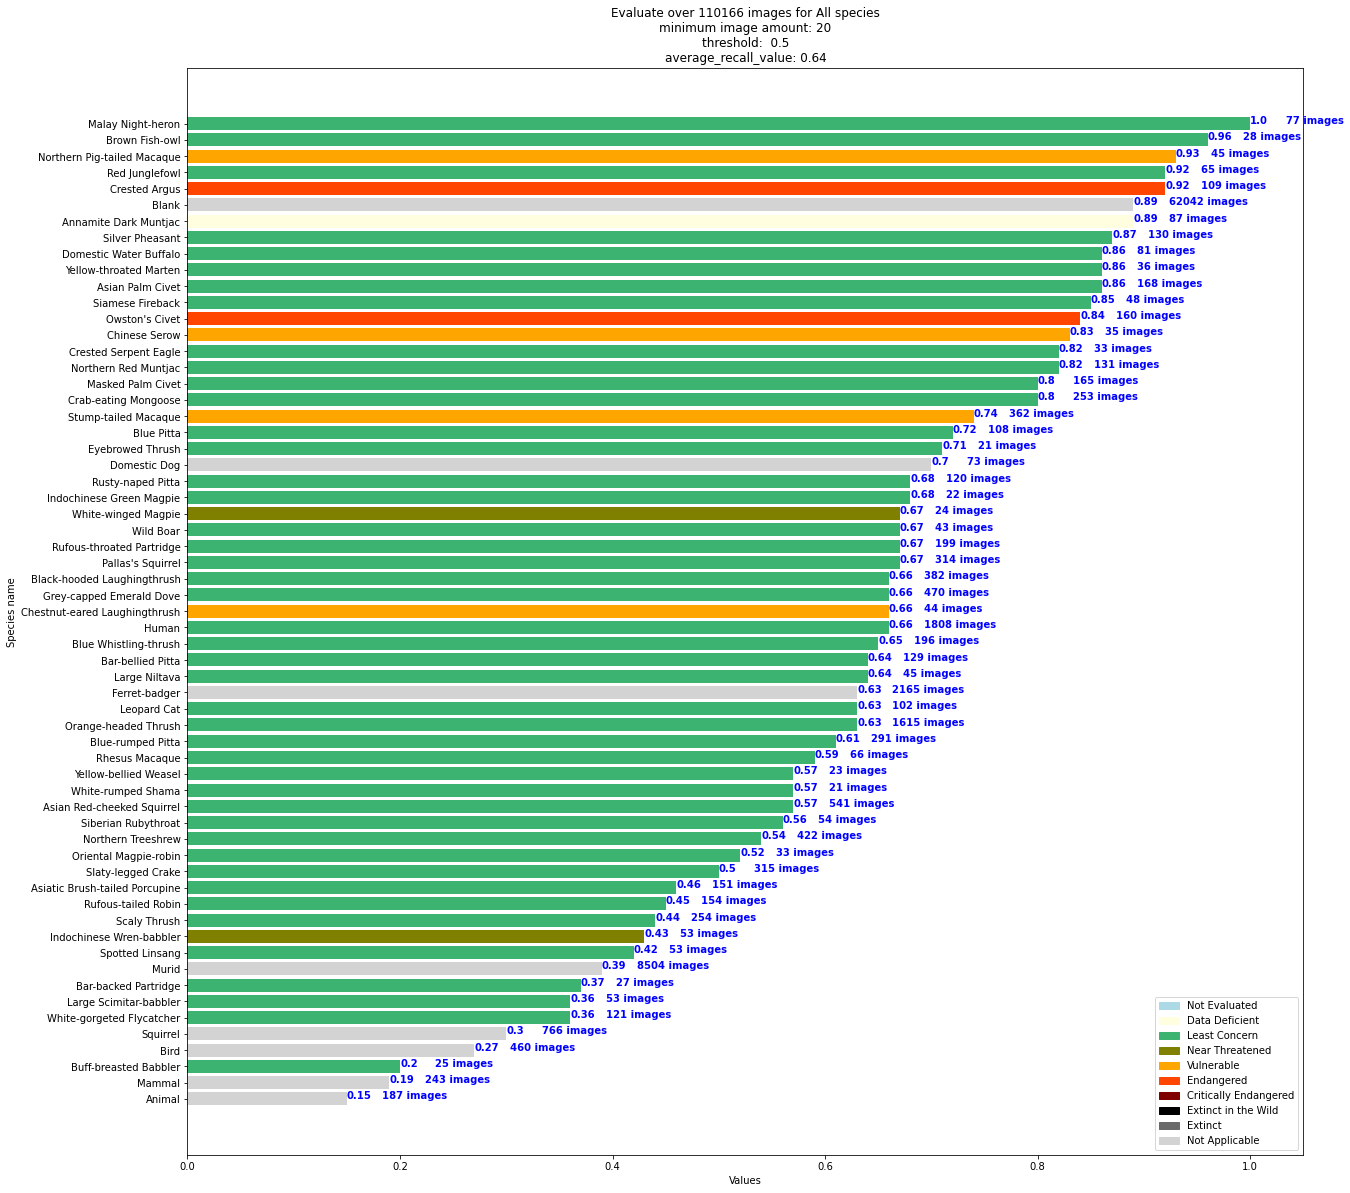

In [68]:
# draw bar graph
visualize_recall_bargraph('All species', 
                          confusion_matrix, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=20, 
                          legend_by_color=True, 
                          custom_size=(20,20),
                          save_fig="by independent event/MD_recall_Kon-Plong_all-species_min-20-images.jpg")

Generating visualization plot for Large groups...
File is saved to by independent event/MD_recall_Kon-Plong_big-groups.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_big-groups.jpg


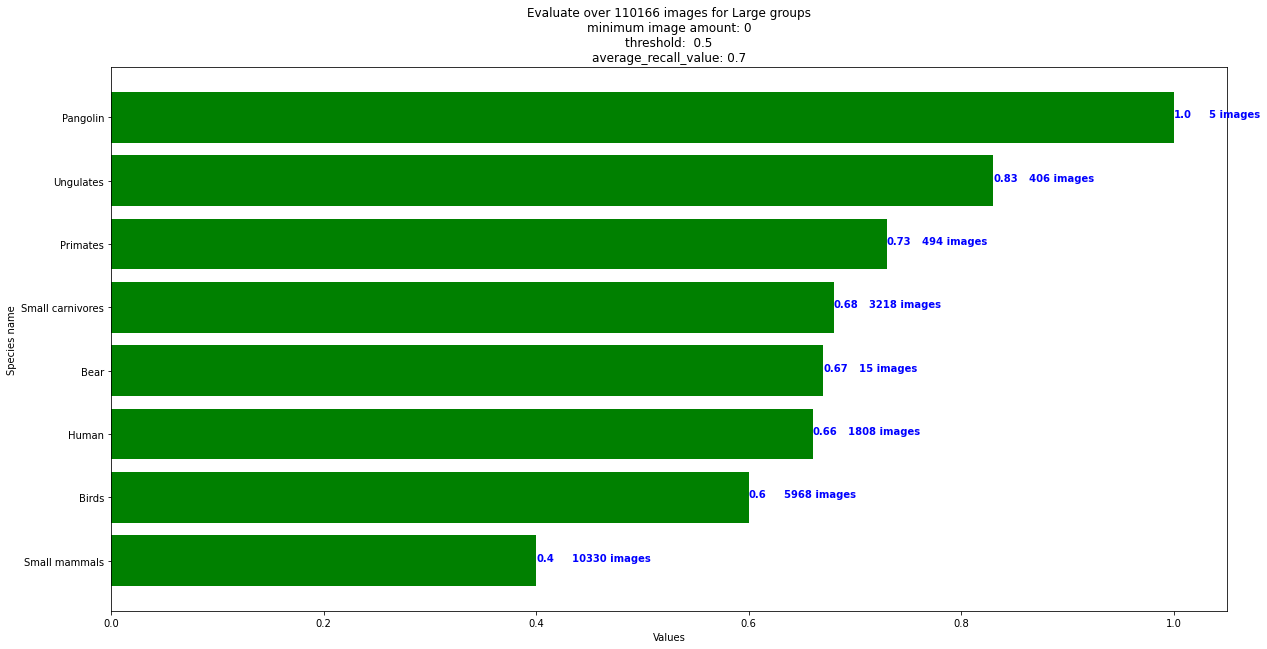

In [69]:
# by large group
colors_large_group = {}
for species in confusion_matrix_by_group.columns:
  colors_large_group[species] = 'green'
visualize_recall_bargraph('Large groups', 
                          confusion_matrix_by_group, 
                          threshold=0.5, 
                          color_dict=colors_large_group, 
                          legend_by_color=False,
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_big-groups.jpg")

Generating visualization plot for Vulnerable+ species...
File is saved to by independent event/MD_recall_Kon-Plong_VU-EN-CR.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_VU-EN-CR.jpg


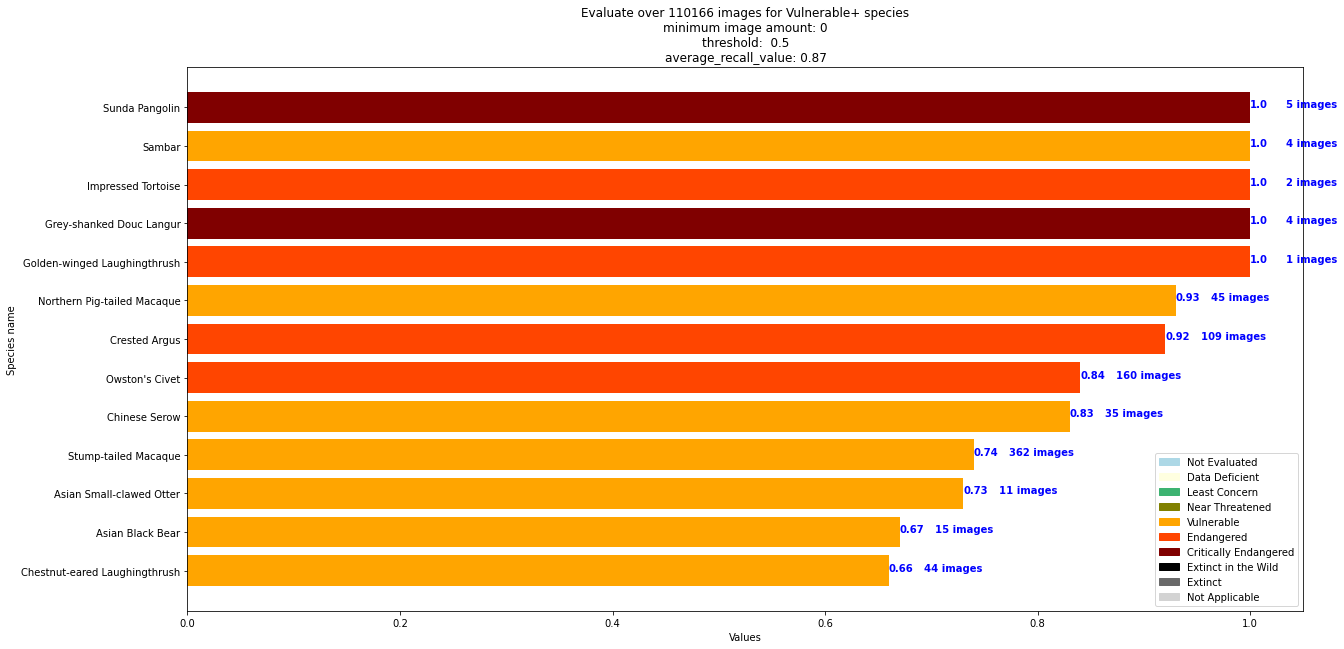

In [70]:
# in rare group
visualize_recall_bargraph('Vulnerable+ species', 
                          confusion_matrix_by_conservation_status, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_VU-EN-CR.jpg")

Generating visualization plot for Ungulates...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Ungulates.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Ungulates.jpg


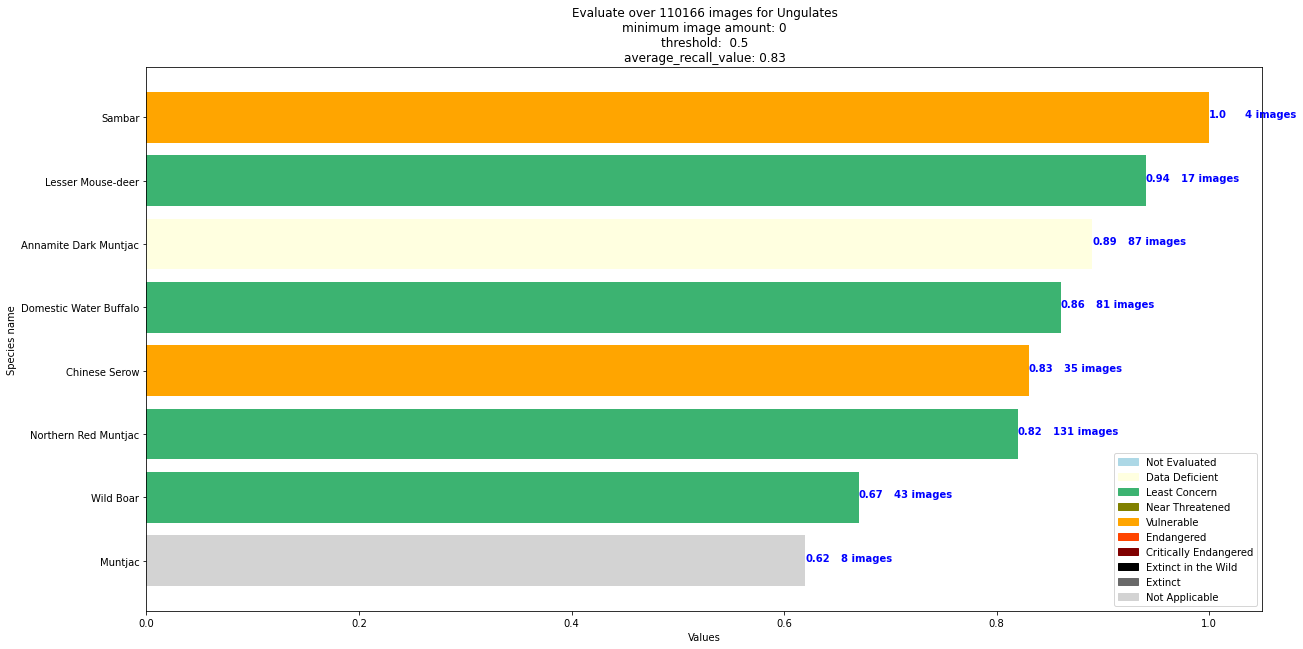

In [71]:
# in Ungulates
confusion_matrix_in_Ungulates_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Ungulates', 'order', 'Cetartiodactyla', []])
visualize_recall_bargraph('Ungulates', 
                          confusion_matrix_in_Ungulates_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Ungulates.jpg")

Generating visualization plot for Birds...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Birds.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Birds.jpg


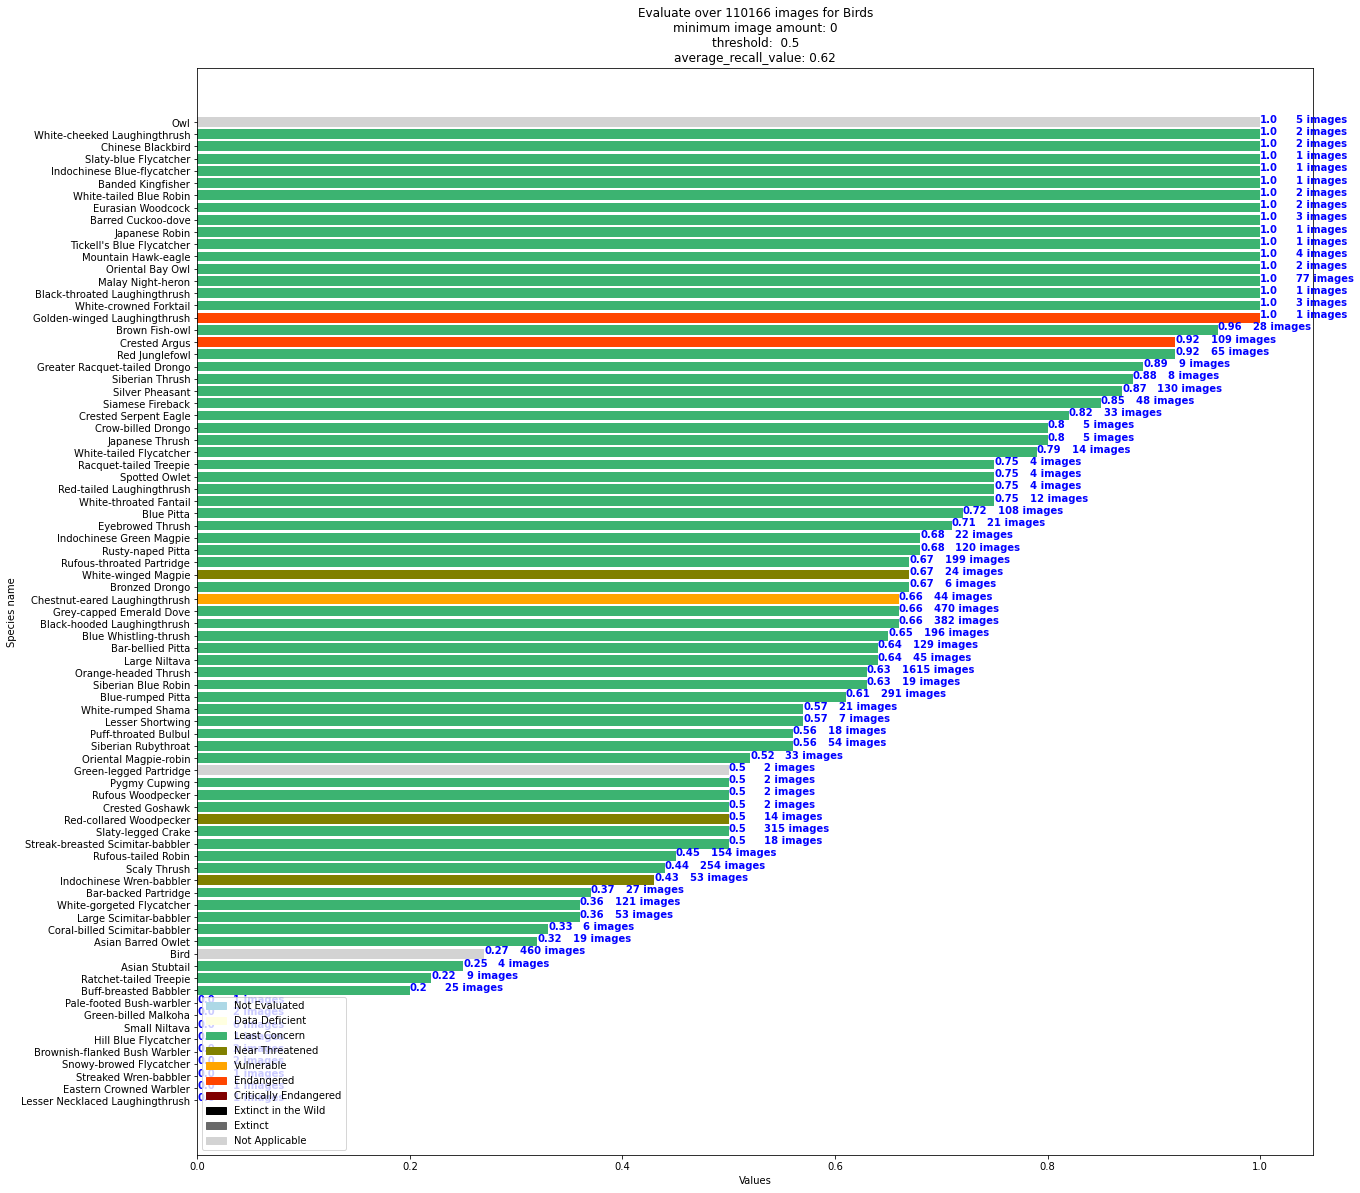

In [72]:
# in Birds
confusion_matrix_in_Birds_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Birds', 'class', 'Aves', []])
visualize_recall_bargraph('Birds', 
                          confusion_matrix_in_Birds_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,20),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Birds.jpg")

Generating visualization plot for Small carnivores...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Small-carnivores.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Small-carnivores.jpg


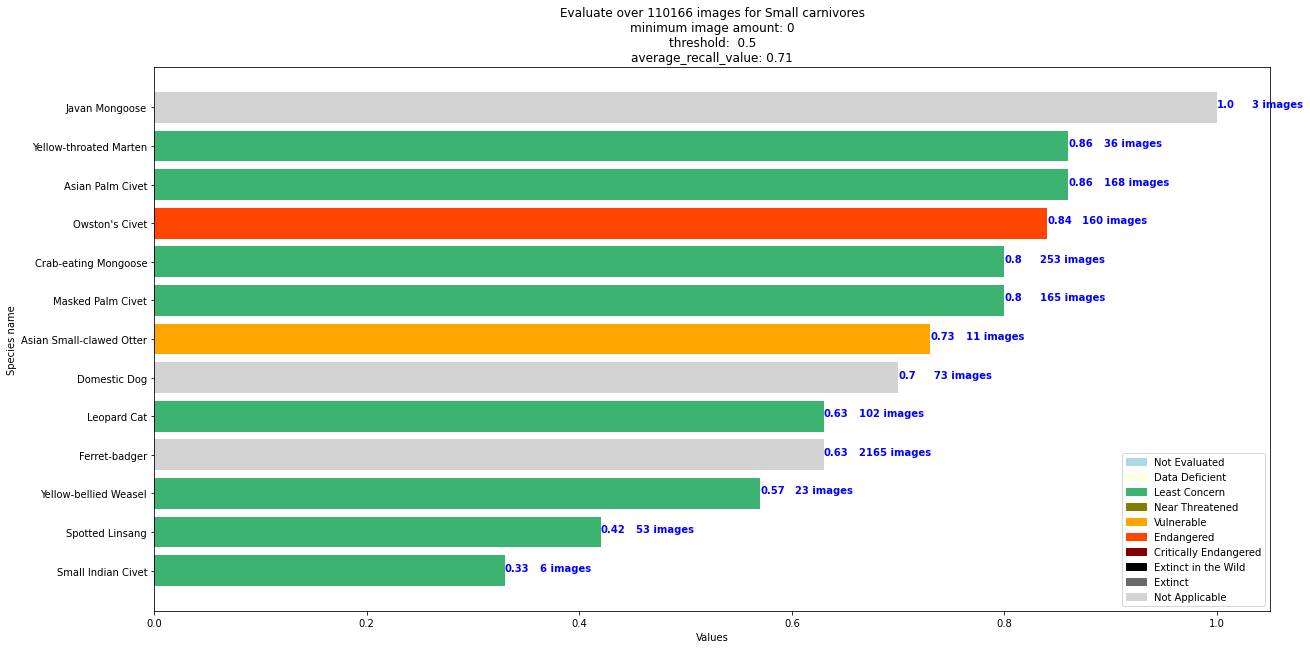

In [73]:
# in Small carnivores
confusion_matrix_in_Small_carnivores_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Small carnivores', 'order', 'Carnivora', ["Asian Black Bear"]])
visualize_recall_bargraph('Small carnivores', 
                          confusion_matrix_in_Small_carnivores_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Small-carnivores.jpg")

Generating visualization plot for Small mammals...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Small-mammals.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Small-mammals.jpg


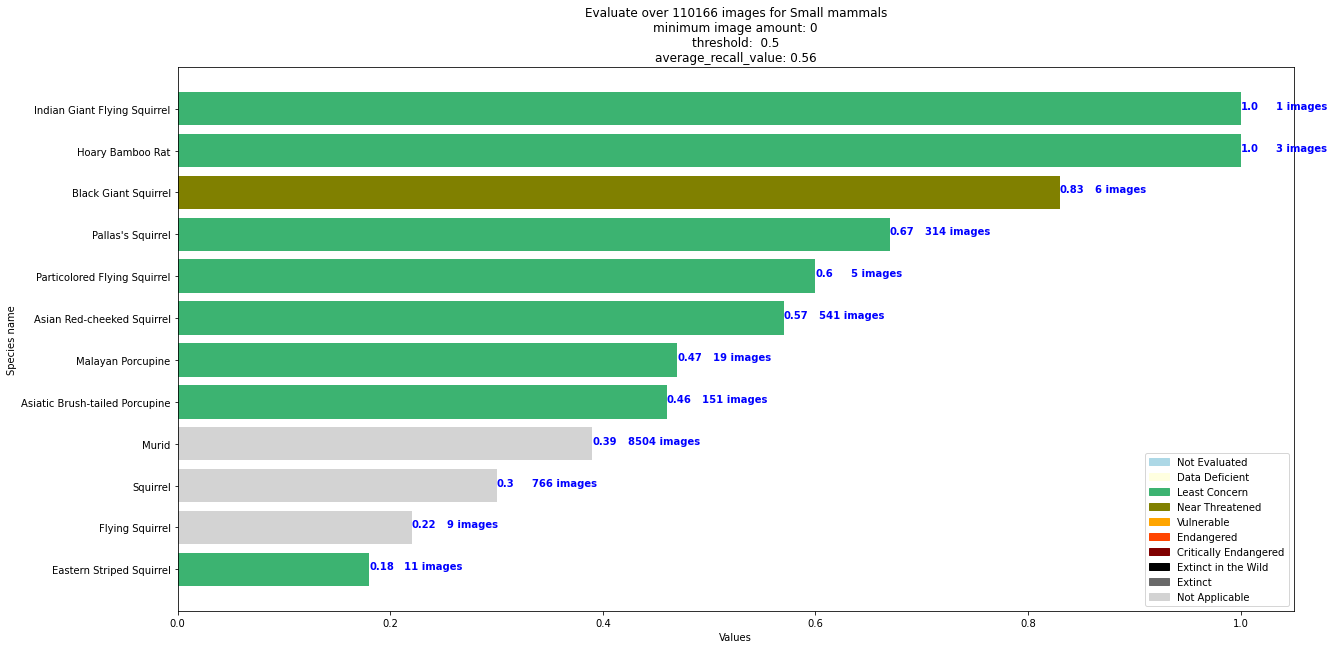

In [74]:
# in Small mammals
confusion_matrix_in_Small_mammal_sgroup = create_confusion_matrix_in_group(taxon_match_table, 
                                                                           confusion_matrix, 
                                                                           ['Small mammals', 'order', 'Rodentia', []])
visualize_recall_bargraph('Small mammals', 
                          confusion_matrix_in_Small_mammal_sgroup, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Small-mammals.jpg")


Generating visualization plot for Primates...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Primates.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Primates.jpg


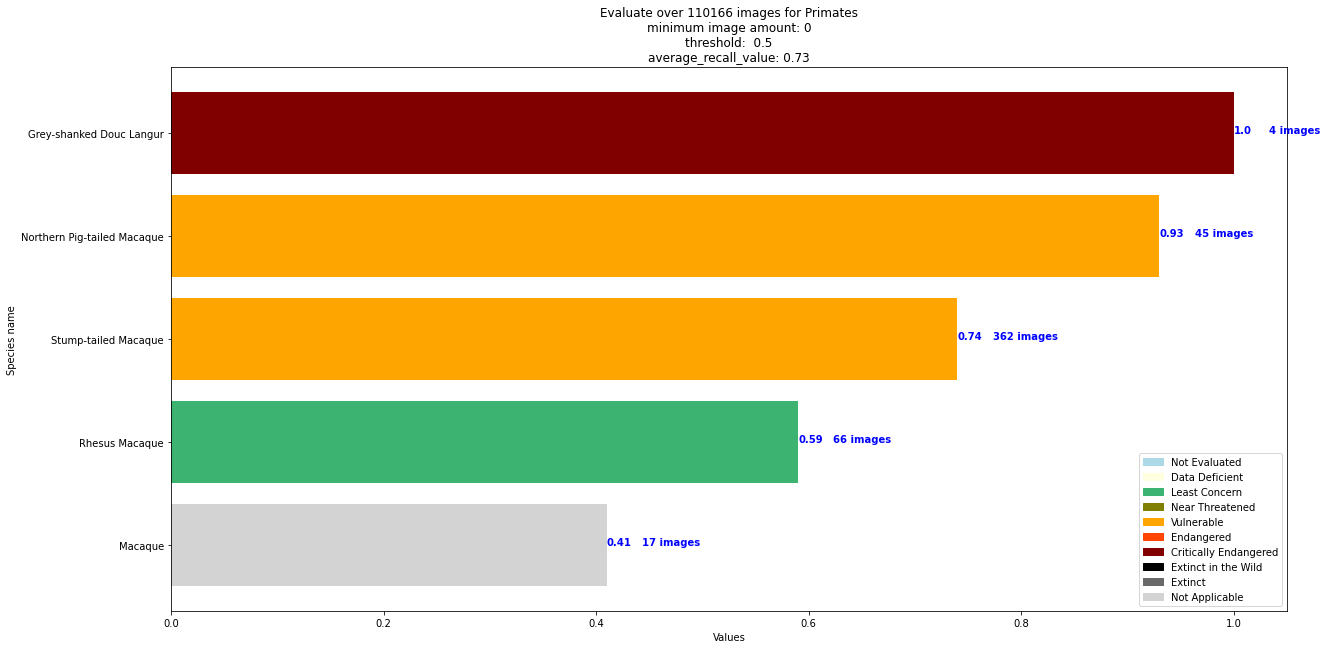

In [75]:
# in Primates
confusion_matrix_in_Primates_group = create_confusion_matrix_in_group(taxon_match_table, 
                                                                      confusion_matrix, 
                                                                      ['Primates', 'order', 'Primates', ['Human']])
visualize_recall_bargraph('Primates', 
                          confusion_matrix_in_Primates_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Primates.jpg")

Generating visualization plot for Bear...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Bear.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Bear.jpg


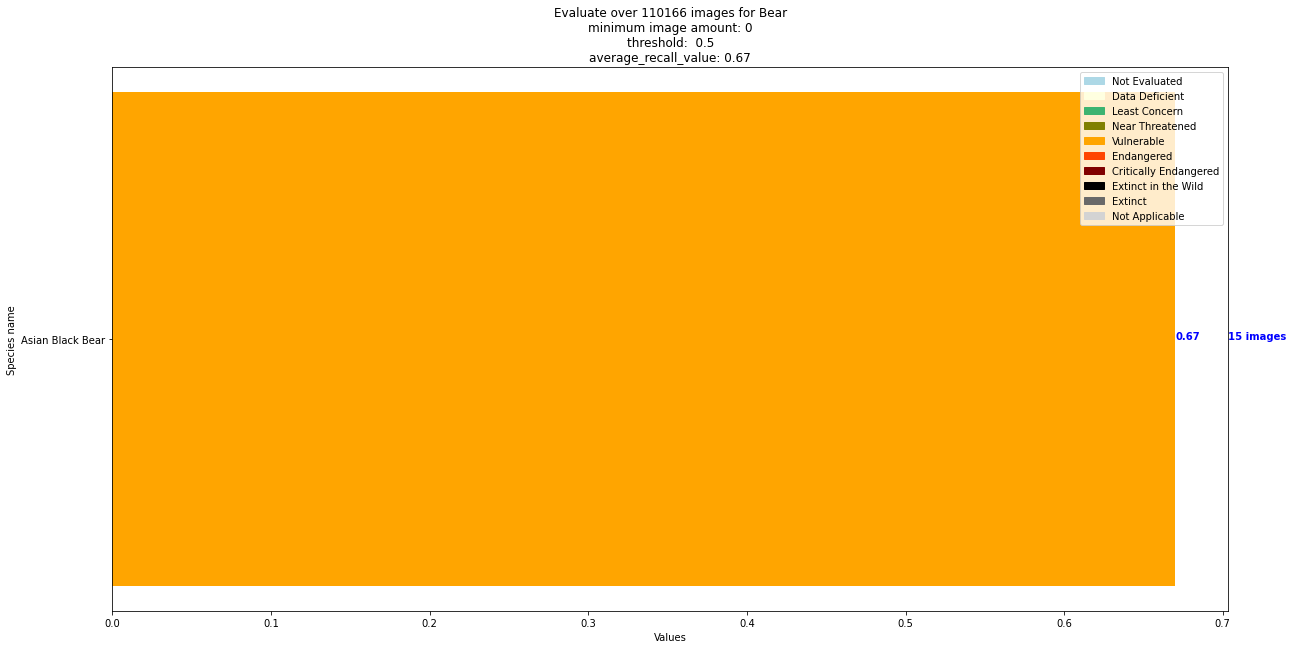

In [76]:
# in Bear
confusion_matrix_in_Bear_group = create_confusion_matrix_in_group(taxon_match_table, 
                                                                  confusion_matrix, 
                                                                  ['Bear', 'family', 'Ursidae', []])
visualize_recall_bargraph('Bear', 
                          confusion_matrix_in_Bear_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Bear.jpg")

Generating visualization plot for Pangolin...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Pangolin.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Pangolin.jpg


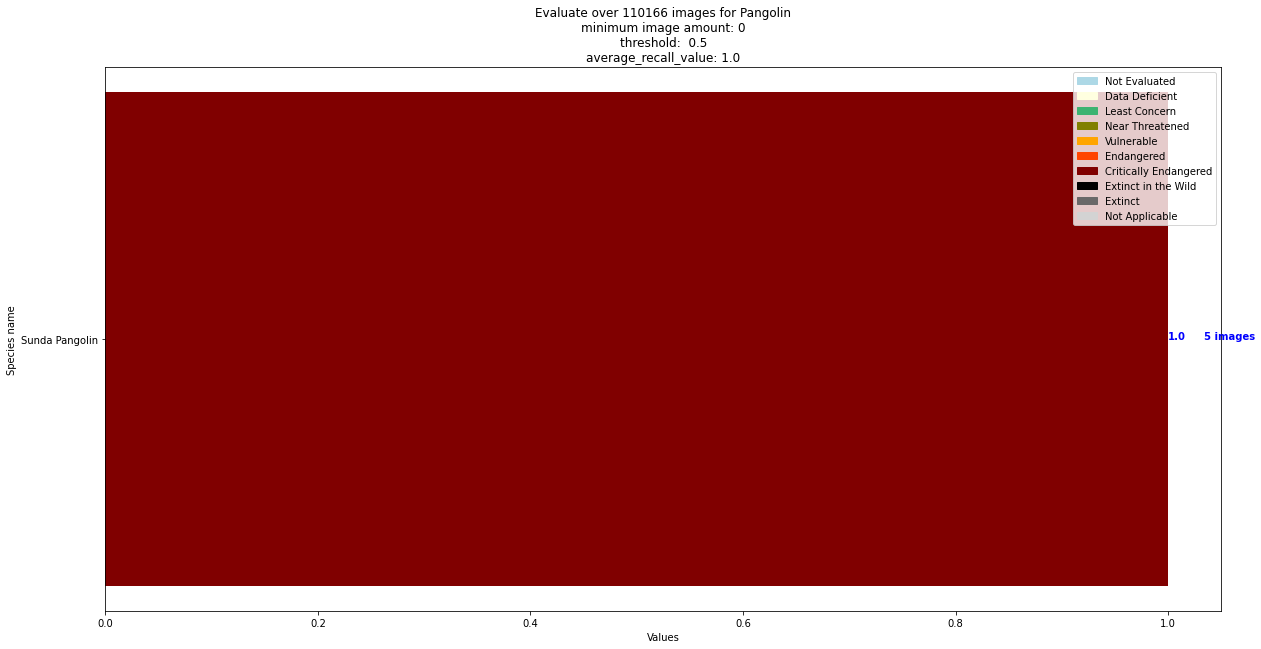

In [77]:
# in Pangolin
confusion_matrix_in_Pangolin_group = create_confusion_matrix_in_group(taxon_match_table, 
                                                                      confusion_matrix, 
                                                                      ['Pangolin', 'family', 'Manidae', []])
visualize_recall_bargraph('Pangolin', 
                          confusion_matrix_in_Pangolin_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Pangolin.jpg")